In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Mounted at /content/drive
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


In [ ]:
!pip install timm torch torchvision scikit-learn tqdm

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch 1/5


/tmp/ipython-input-874681795.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-874681795.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 1.8359 Acc: 0.4239
Val Loss: 4.1003 Acc: 0.4554
Epoch 2/5
Train Loss: 1.3740 Acc: 0.5116
Val Loss: 23.4598 Acc: 0.5081
Epoch 3/5
Train Loss: 1.2022 Acc: 0.5485
Val Loss: 25.4801 Acc: 0.5264
Epoch 4/5
Train Loss: 1.1247 Acc: 0.5702
Val Loss: 98.3478 Acc: 0.5426
Epoch 5/5
Train Loss: 1.0905 Acc: 0.5774
Val Loss: 2.2919 Acc: 0.5507
Epoch 1/40
Train Loss: 1.0774 Acc: 0.5798
Val Loss: 34.1352 Acc: 0.5690
Epoch 2/40
Train Loss: 0.9390 Acc: 0.6308
Val Loss: 11.6606 Acc: 0.5872
Epoch 3/40
Train Loss: 0.8734 Acc: 0.6458
Val Loss: 6.4977 Acc: 0.6014
Epoch 4/40
Train Loss: 0.8382 Acc: 0.6510
Val Loss: 39.4251 Acc: 0.5994
Epoch 5/40
Train Loss: 0.7967 Acc: 0.6758
Val Loss: 6.3012 Acc: 0.5963
Epoch 6/40
Train Loss: 0.7836 Acc: 0.6784
Val Loss: 2.3513 Acc: 0.6146
Epoch 7/40
Train Loss: 0.7251 Acc: 0.6936
Val Loss: 49.6424 Acc: 0.6329
Epoch 8/40
Train Loss: 0.7135 Acc: 0.7053
Val Loss: 70.9737 Acc: 0.6237
Epoch 9/40
Train Loss: 0.6773 Acc: 0.7166
Val Loss: 0.8608 Acc: 0.6430
Epoch 10/40
T

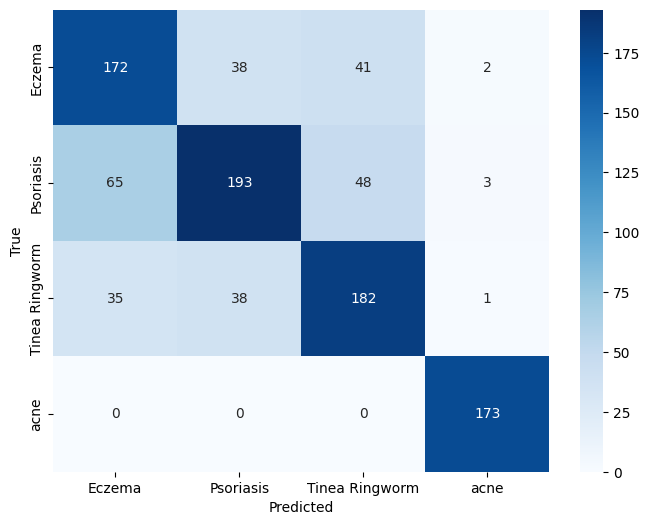

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm

# ======================================================
# Config
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/DATA"  # adjust to your extracted dataset path
batch_size = 16  # keep small if GPU OOM
num_epochs_head = 5
num_epochs_full = 40
lr_head = 1e-3
lr_full = 1e-5

# ======================================================
# Data Augmentation
# ======================================================
train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ======================================================
# Datasets & Loaders
# ======================================================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

class_names = train_dataset.classes

# Balanced Sampler
class_counts = np.bincount([y for _, y in train_dataset.samples])
class_weights = 1. / class_counts
weights = [class_weights[y] for _, y in train_dataset.samples]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ======================================================
# Model: EfficientNet-B3
# ======================================================
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=len(class_names))
model = model.to(device)

# ======================================================
# Training Functions
# ======================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # -------- Training --------
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # -------- Validation --------
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

    model.load_state_dict(best_model_wts)
    return model, history


# ======================================================
# Step 1: Train classifier head only
# ======================================================
for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.get_classifier().parameters(), lr=lr_head)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs_head)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs_head)

# ======================================================
# Step 2: Fine-tune entire model
# ======================================================
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=lr_full)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs_full)

history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs_full)

# ======================================================
# Evaluation with TTA
# ======================================================
def predict_tta(model, img, device):
    model.eval()
    transforms_tta = [
        transforms.Compose([transforms.Resize((384,384)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
        transforms.Compose([transforms.Resize((384,384)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
        transforms.Compose([transforms.Resize((384,384)), transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
        transforms.Compose([transforms.Resize((384,384)), transforms.RandomRotation(15), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    ]
    preds = []
    with torch.no_grad():
        for t in transforms_tta:
            x = t(img).unsqueeze(0).to(device)
            preds.append(torch.softmax(model(x), dim=1))
    return torch.mean(torch.stack(preds), dim=0)

# ======================================================
# Test Evaluation
# ======================================================
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()